# 4 Convolutional Neural Networks - image segmentation (TensorFlow)

## 4.1 Image and Label Data
**WARNING:** This file is not currently compatible with Google Colab due to accessing large files. The interested can look into [Colab IO][colab_io], e.g.:
```python
from google.colab import files
files.upload()
```
This also means that TensorFlow needs to be [installed locally][tf_install] to run this file. Alternatively, Anaconda can also [work with TensoFlow][tf_conda].

The images and labels (segmentations) in [PROMISE12][promise12] are used here. Resampled data can be downloaded here:

[Download Data][data_link]

Then, unzip the zip file to individual npy files by running the following python script [*unzip_files*][unzip_files.py]. By default, the script is looking the downloaded zip file in Downloads folder under user home directory and save all the unzipped files in data folder under working directory.

On Linux:
```console
python3 ./data/unzip_files.py 
```

Or:

[colab_io]: https://colab.research.google.com/notebooks/io.ipynb
[tf_install]: https://www.tensorflow.org/install/
[tf_conda]: https://www.anaconda.com/blog/developer-blog/tensorflow-in-anaconda/
[promise12]: https://promise12.grand-challenge.org/
[data_link]: https://github.com/YipengHu/promise12/archive/data.zip
[unzip_files.py]: ./data/unzip_files.py

In [3]:
import data.unzip_files as unzipfiles
import os

# this is where the zip file and the output folder need to be specified
path_to_zip_file = "~/Downloads/promise12-data.zip"
path_to_output_folder = "./data"

path_to_data = unzipfiles.check_and_unzip(path_to_zip_file)

Data saved successfully at: /home/yipenghu/git/ipmi/tutorials/data


The output folder shoud have all the data needed. For those who are interested, the script [*script_promise12*][script_promise12.py] contains code that resampled the original raw data.

Additionally, a package contains several simple utility functions. The [*utilities*][utilities.py] module is in the same github repository. 

Now, check a few images and labels in the folder:

[script_promise12.py]: ./data/script_promise12.py
[utilities.py]: ./utilities.py

(24, 160, 160)
(24, 160, 160)


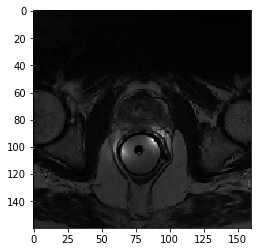

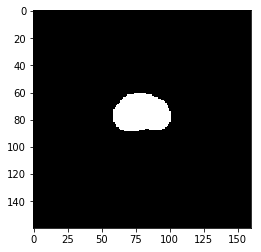

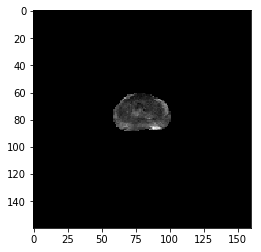

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# load a training image-label pair
idx = 49
image = np.load(os.path.join(path_to_data, "image_train%02d.npy" % idx))
label = np.load(os.path.join(path_to_data, "label_train%02d.npy" % idx))
print(image.shape)
print(label.shape)

# plot the pair
idx_slice = 12
plt.figure()
plt.imshow(image[idx_slice,:,:], cmap='gray')
plt.figure()
plt.imshow(label[idx_slice,:,:], cmap='gray')

# and you can check see if the mask is actually segmenting the ROI
plt.figure()
plt.imshow(image[idx_slice,:,:] * label[idx_slice,:,:], cmap='gray')